# Predizione della Prossima Parola con LSTM e Shakespeare

## 📚 Scopo Didattico
Questo notebook ti insegna a creare un modello di linguaggio che predice la prossima parola in una sequenza di testo, utilizzando reti neurali ricorrenti (LSTM).

## 🎯 Obiettivi
- Implementare un preprocessamento del testo con TextVectorization
- Creare sequenze n-gram per l'addestramento
- Costruire un modello LSTM per la predizione di parole
- Generare testo in stile Shakespeare

## 📊 Dataset
Utilizziamo i **Sonetti di Shakespeare** - oltre 2000 versi di testo poetico dal corpus completo dei 154 sonetti.

## 🛠 Tecnologie
- **TensorFlow/Keras**: framework di deep learning
- **LSTM**: rete neurale ricorrente per sequenze
- **TextVectorization**: preprocessing moderno del testo
- **Embedding**: rappresentazione densa delle parole

## 📝 Struttura del Notebook
1. Importazione librerie e setup
2. Caricamento e analisi del dataset
3. Creazione del vectorizer (tokenizzazione)
4. Generazione delle sequenze n-gram
5. Preparazione del dataset per il training
6. Creazione del modello LSTM
7. Addestramento
8. Generazione di testo

In [ ]:
# Librerie necessarie
import numpy as np              # Operazioni numeriche
import matplotlib.pyplot as plt  # Visualizzazione grafici
import tensorflow as tf          # Framework di deep learning
import pickle                    # Salvataggio oggetti Python

print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.19.0


In [ ]:
from google.colab import files

# Upload del file dei sonetti
uploaded = files.upload()

# Il file sarà salvato nella directory corrente
# Rinominiamo per comodità se necessario
import os
uploaded_filename = list(uploaded.keys())[0]
if uploaded_filename != 'sonnets.txt':
    os.rename(uploaded_filename, 'sonnets.txt')
print("✓ File caricato con successo!")

Saving sonnets.txt to sonnets.txt
✓ File caricato con successo!


## ⚙️ Configurazione Parametri

Definiamo i parametri principali del modello:
- **NUM_BATCHES**: dimensione del batch per l'addestramento
- **LSTM_UNITS**: numero di unità nella rete LSTM (memoria del modello)
- **EMBEDDING_DIM**: dimensioni del vettore di embedding per ogni parola

In [ ]:
# Percorso del file (ora nella directory corrente di Colab)
FILE_PATH = 'sonnets.txt'

# Iperparametri del modello
NUM_BATCHES = 16        # Numero di esempi per batch
LSTM_UNITS = 128        # Unità LSTM (capacità memoria)
EMBEDDING_DIM = 100     # Dimensioni embedding

print(f"Configurazione:")
print(f"  - Batch size: {NUM_BATCHES}")
print(f"  - LSTM units: {LSTM_UNITS}")
print(f"  - Embedding dimensions: {EMBEDDING_DIM}")

Configurazione:
  - Batch size: 16
  - LSTM units: 128
  - Embedding dimensions: 100


## 📖 Caricamento e Analisi del Dataset

Leggiamo il file dei sonetti di Shakespeare e lo prepariamo per l'elaborazione:
- Convertiamo tutto in minuscolo per uniformità
- Dividiamo il testo in righe separate
- Ogni riga diventerà una sequenza di training

In [ ]:
# Leggiamo il file dei sonetti
with open(FILE_PATH) as f:
  data = f.read()

# Convertiamo tutto in minuscolo e dividiamo in righe
corpus = data.lower().split("\n")

# Informazioni sul dataset
print(f"📊 Statistiche del corpus:")
print(f"   Numero totale di righe: {len(corpus)}\n")
print(f"📝 Prime 5 righe del corpus:\n")
for i in range(5):
    print(f"   {i+1}. {corpus[i]}")

📊 Statistiche del corpus:
   Numero totale di righe: 2159

📝 Prime 5 righe del corpus:

   1. from fairest creatures we desire increase,
   2. that thereby beauty's rose might never die,
   3. but as the riper should by time decease,
   4. his tender heir might bear his memory:
   5. but thou, contracted to thine own bright eyes,


## 🔧 Esercizio 1: Creazione del TextVectorizer

Il **TextVectorization** è un layer di Keras che:
1. **Tokenizza** il testo (divide in parole)
2. **Crea un vocabolario** (dizionario parola → numero)
3. **Converte** le parole in sequenze numeriche

### Caratteristiche importanti:
- Rimuoviamo la punteggiatura automaticamente
- Convertiamo tutto in minuscolo
- Non facciamo padding qui (lo faremo dopo aver creato gli n-gram)
- Usiamo `ragged=True` per gestire sequenze di lunghezza variabile

In [ ]:
def fit_vectorizer(corpus):
  # Seed per riproducibilità
  tf.keras.utils.set_random_seed(65)
  # Definiamo il vettorizzatore ed adattiamolo al testo
  vectorizer = tf.keras.layers.TextVectorization(
      standardize = 'lower_and_strip_punctuation',
      ragged = True,
      output_mode = 'int'
  )

  # Adattiamolo al testo
  vectorizer.adapt(corpus)

  return vectorizer

In [ ]:
# Creiamo e testiamo il vectorizer
vectorizer = fit_vectorizer(corpus)

# Otteniamo la dimensione del vocabolario
total_words = len(vectorizer.get_vocabulary())

print(f"✓ Vectorizer creato con successo!")
print(f"📚 Numero totale di parole nel vocabolario: {total_words}")
print(f"\n🔤 Prime 10 parole del vocabolario:")
for i, word in enumerate(vectorizer.get_vocabulary()[:10]):
    print(f"   {i}: '{word}'")

✓ Vectorizer creato con successo!
📚 Numero totale di parole nel vocabolario: 3189

🔤 Prime 10 parole del vocabolario:
   0: ''
   1: '[UNK]'
   2: 'and'
   3: 'the'
   4: 'to'
   5: 'of'
   6: 'my'
   7: 'i'
   8: 'in'
   9: 'that'


## 🧪 Test del Vectorizer

Vediamo come funziona la conversione testo → numeri:

In [ ]:
# Testiamo con una frase di esempio
test_sentence = "Shall I compare thee to a summer's day?"

# Convertiamo in sequenza numerica
token_list = vectorizer(test_sentence)

print(f"Frase originale:")
print(f"   '{test_sentence}'\n")
print(f"Sequenza numerica:")
print(f"   {token_list.numpy()}\n")

# Decodifichiamo per vedere la corrispondenza
vocab = vectorizer.get_vocabulary()
print(f"Corrispondenza parola → indice:")
for idx in token_list.numpy():
    print(f"   {idx} → '{vocab[idx]}'")

Frase originale:
   'Shall I compare thee to a summer's day?'

Sequenza numerica:
   [ 48   7 405  19   4  18 200 108]

Corrispondenza parola → indice:
   48 → 'shall'
   7 → 'i'
   405 → 'compare'
   19 → 'thee'
   4 → 'to'
   18 → 'a'
   200 → 'summers'
   108 → 'day'


## 🔢 Creazione delle Sequenze N-gram

### Cosa sono gli N-gram?

Un **n-gram** è una sequenza di N parole consecutive. Per addestrare il modello a predire la prossima parola, creiamo tutte le possibili sotto-sequenze di ogni frase.

### Esempio pratico:

Frase: "I love deep learning"
- Token: [5, 10, 25, 40]

N-gram generati:
- [5, 10] → predice 25
- [5, 10, 25] → predice 40
- [5, 10, 25, 40] → completo

### Perché è importante?

Il modello impara a predire la parola successiva basandosi sul contesto precedente di lunghezza variabile.

In [ ]:
def n_gram_seqs(corpus, vectorizer):
  # Generiamo tutte le sequenze n-gram da corpus
  input_sequences = []  # Lista per raccogliere tutti gli n-gram
  # Iteriamo su ogni riga del corpus
  for sentence in corpus:
    # Convertiamo la frase in sequenza di token numerici
    token_list = vectorizer(sentence).numpy()
    # Creaimao tutti gli n-gram possibili per questa frase
    # Partiamo da 2 token (minimo per avere input e output)
    for i in range(2, len(token_list) + 1):
      # Prendiamo i primi token come n_gram
      n_gram_sequence = token_list[:i]
      # Aggiungiamolo alla lista
      input_sequences.append(n_gram_sequence)

  return input_sequences

In [ ]:
# Generiamo gli n-gram
input_sequences = n_gram_seqs(corpus, vectorizer)

print(f"✓ N-gram generati con successo!")
print(f"📊 Numero totale di sequenze create: {len(input_sequences)}")
print(f"\n🔍 Esempio di sequenze (prime 5):")

# Mostriamo alcuni esempi
vocab = vectorizer.get_vocabulary()
for i, seq in enumerate(input_sequences[:5]):
    # Decodifichiamo la sequenza
    words = [vocab[idx] for idx in seq]
    print(f"   {i+1}. Token: {seq} → Parole: {words}")

✓ N-gram generati con successo!
📊 Numero totale di sequenze create: 15355

🔍 Esempio di sequenze (prime 5):
   1. Token: [ 35 489] → Parole: [np.str_('from'), np.str_('fairest')]
   2. Token: [  35  489 1259] → Parole: [np.str_('from'), np.str_('fairest'), np.str_('creatures')]
   3. Token: [  35  489 1259  164] → Parole: [np.str_('from'), np.str_('fairest'), np.str_('creatures'), np.str_('we')]
   4. Token: [  35  489 1259  164  230] → Parole: [np.str_('from'), np.str_('fairest'), np.str_('creatures'), np.str_('we'), np.str_('desire')]
   5. Token: [  35  489 1259  164  230  582] → Parole: [np.str_('from'), np.str_('fairest'), np.str_('creatures'), np.str_('we'), np.str_('desire'), np.str_('increase')]


## 📏 Padding delle Sequenze

Le sequenze hanno lunghezze diverse, ma le reti neurali richiedono input di dimensione fissa.

### Soluzione: Padding

Aggiungiamo zeri all'inizio (pre-padding) per portare tutte le sequenze alla stessa lunghezza.

**Esempio:**
```
[5, 10]         → [0, 0, 0, 5, 10]
[5, 10, 25]     → [0, 0, 5, 10, 25]
[5, 10, 25, 40] → [0, 5, 10, 25, 40]
```

La lunghezza massima sarà quella della sequenza più lunga nel dataset.

In [ ]:
def pad_seqs(input_sequences):
  # Troviamo la lunghezza della sequenza più lunga
  max_sequence_len = max([len(seq) for seq in input_sequences])
  # Applichiamo il padding a tutte le sequenze
  # padding = 'pre' - aggiungiamo gli zeri all'inizio
  # maxlen - lunghezza target
  input_sequences = tf.keras.preprocessing.sequence.pad_sequences(
      input_sequences,
      maxlen = max_sequence_len,
      padding = "pre"
  )
  return input_sequences, max_sequence_len

In [ ]:
# Applichiamo il padding
input_sequences, max_sequence_len = pad_seqs(input_sequences)

print(f"✓ Padding applicato!")
print(f"📏 Lunghezza massima delle sequenze: {max_sequence_len}")
print(f"📦 Shape finale del dataset: {input_sequences.shape}")
print(f"\n🔍 Esempio di sequenze con padding (prime 3):")

vocab = vectorizer.get_vocabulary()
for i in range(3):
    seq = input_sequences[i]
    # Mostriamo solo le parole non-zero
    non_zero = seq[seq != 0]
    words = [vocab[idx] for idx in non_zero]
    print(f"   {i+1}. {seq} → {words}")

✓ Padding applicato!
📏 Lunghezza massima delle sequenze: 11
📦 Shape finale del dataset: (15355, 11)

🔍 Esempio di sequenze con padding (prime 3):
   1. [  0   0   0   0   0   0   0   0   0  35 489] → [np.str_('from'), np.str_('fairest')]
   2. [   0    0    0    0    0    0    0    0   35  489 1259] → [np.str_('from'), np.str_('fairest'), np.str_('creatures')]
   3. [   0    0    0    0    0    0    0   35  489 1259  164] → [np.str_('from'), np.str_('fairest'), np.str_('creatures'), np.str_('we')]


## 🎯 Separazione Features e Labels

### Struttura dei dati

Ogni sequenza n-gram deve essere divisa in:
- **Features (X)**: tutte le parole tranne l'ultima → contesto
- **Labels (y)**: l'ultima parola → target da predire

### Esempio:
```
Sequenza: [0, 5, 10, 25, 40]
Features: [0, 5, 10, 25]     → input del modello
Label:    40                  → output da predire
```

### One-Hot Encoding per le Labels

Le labels vengono convertite in vettori one-hot per classificazione multi-classe:
- Se abbiamo 3189 parole nel vocabolario
- Label 40 diventa un vettore con 3189 elementi
- Tutti zeri tranne posizione 40 che vale 1

In [ ]:
def features_and_labels(input_sequences, total_words):
  # Sepriamo le sequenze in features (x) e labels (y)
  # Quindi separiamo features (tutte tranne ultima parola) e labels (ultima parola)
  features = input_sequences[:, :-1]    # Tutte le colonne tranne l'ultima
  labels = input_sequences[:, -1]       # Solo l'ultima

  # Trasformiamo le etichette in vettori pi probabilità (0 e 1) per il layer di output della rete
  # One-Hot Encoding: converte l'indice intero (es. 3) in unvettore binario (es. [0,0,0,1,...])
  one_hot_labels = tf.keras.utils.to_categorical(
      labels,
      num_classes = total_words
  )
  return features, one_hot_labels

In [ ]:
# Creiamo features e labels
features, labels = features_and_labels(input_sequences, total_words)

print(f"✓ Features e labels create!")
print(f"\n📊 Dimensioni:")
print(f"   Features shape: {features.shape}")
print(f"   Labels shape:   {labels.shape}")

print(f"\n🔍 Esempio (prima sequenza):")
print(f"   Feature (input):  {features[0]}")
print(f"   Label (target):   index {np.argmax(labels[0])} → '{vectorizer.get_vocabulary()[np.argmax(labels[0])]}'")

print(f"\n💡 Interpretazione:")
print(f"   - Ogni riga è una sequenza di {features.shape[1]} token")
print(f"   - Il modello predice 1 parola tra {labels.shape[1]} possibili")

✓ Features e labels create!

📊 Dimensioni:
   Features shape: (15355, 10)
   Labels shape:   (15355, 3189)

🔍 Esempio (prima sequenza):
   Feature (input):  [ 0  0  0  0  0  0  0  0  0 35]
   Label (target):   index 489 → 'fairest'

💡 Interpretazione:
   - Ogni riga è una sequenza di 10 token
   - Il modello predice 1 parola tra 3189 possibili


## 🔄 Creazione del Dataset

### Perché usare tf.data.Dataset?

Il `tf.data.Dataset` offre:
- **Efficienza**: caricamento ottimizzato dei dati
- **Batching**: raggruppa esempi per il training
- **Shuffling**: mescola i dati per migliorare l'apprendimento
- **Prefetching**: prepara i batch in anticipo

### Configurazione:
- Mescoliamo il dataset (shuffle)
- Dividiamo in batch di dimensione NUM_BATCHES
- Usiamo prefetch per ottimizzare le performance

In [ ]:
def create_dataset(features, labels, num_batches):
    # Creiamo un tf.data.Dataset ottimizzato per il training prendendo features e labels
    # IMPORTANTE: assicuriamoci che siano numpy arrays
    dataset = tf.data.Dataset.from_tensor_slices((features, labels))

    # Mescoliamo il dataset (shuffle), importante per il training
    # buffer_size: numero di elementi da cui campionare casualmente
    dataset = dataset.shuffle(buffer_size=len(features))

    # Dividiamo in batch di num_batches esempi
    # drop_remainder=True: elimina l'ultimo batch se incompleto (per avere dimensioni costanti)
    dataset = dataset.batch(num_batches, drop_remainder=True)

    # Prefetch: prepara il prossimo batch mentre il modello elabora quello corrente
    # AUTOTUNE: TensorFlow decide automaticamente il valore ottimale
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

In [ ]:
# Creiamo il dataset
dataset = create_dataset(features, labels, NUM_BATCHES)

print(f"✓ Dataset creato con successo!")
print(f"\n📦 Configurazione:")
print(f"   Batch size: {NUM_BATCHES}")
print(f"   Numero totale di esempi: {len(features)}")
print(f"   Numero di batch: {len(features) // NUM_BATCHES}")

# Testiamo prendendo un batch
for batch_features, batch_labels in dataset.take(1):
    print(f"\n🔍 Dimensioni di un batch:")
    print(f"   Features batch: {batch_features.shape}")
    print(f"   Labels batch:   {batch_labels.shape}")

✓ Dataset creato con successo!

📦 Configurazione:
   Batch size: 16
   Numero totale di esempi: 15355
   Numero di batch: 959

🔍 Dimensioni di un batch:
   Features batch: (16, 10)
   Labels batch:   (16, 3189)


## 🧠 Creazione del Modello LSTM per la predizione della prossima parola

### Architettura della Rete Neurale

Il nostro modello è composto da 4 layer:

1. **Embedding Layer**
   - Converte indici delle parole in vettori densi
   - Riduce la dimensionalità (da vocabolario a EMBEDDING_DIM)
   - Cattura relazioni semantiche tra parole

2. **Bidirectional LSTM**
   - Legge la sequenza in entrambe le direzioni (avanti e indietro)
   - Cattura dipendenze a lungo termine
   - Doppia memoria contestuale

3. **Dense Layer (nascosto)**
   - Layer completamente connesso
   - Funzione di attivazione ReLU
   - Estrae features complesse

4. **Dense Layer (output)**
   - Predice la probabilità per ogni parola del vocabolario
   - Softmax: output tra 0 e 1, somma = 1
   - Dimensione = total_words

### Loss Function e Optimizer
- **Loss**: `categorical_crossentropy` (classificazione multi-classe)
- **Optimizer**: `adam` (adattivo, efficiente)
- **Metrica**: `accuracy` (percentuale di predizioni corrette)

In [ ]:
def create_model(total_words, max_sequence_len):
  # Definiamo la dimensione dell'input
  # max_sequence_len -1 perché abbiamo rimosso l'ultima parola (label)
  input_len = max_sequence_len -1

  # Creiamo il modello sequenziale
  model = tf.keras.models.Sequential([
      # EMBEDDING LAYER
      # Converte indici delle parole in vettori densi
      # input_dim: dimensione vocabolario (quante parole diverse)
      # output_dim: dimensione del vettore embedding
      # input_length: lunghezza delle sequenze
      tf.keras.layers.Embedding(
          input_dim = total_words,
          output_dim = EMBEDDING_DIM,
          input_length = input_len
      ),

      # BIDIRECTIONAL LSTM
      # Legge la sequenza in entrambe le direzioni
      # UNITS: numero di celle LSTM (memoria del modello)
      tf.keras.layers.Bidirectional(
          tf.keras.layers.LSTM(LSTM_UNITS)
      ),

      # DENSE LAYER (nascoso)
      # Layer completamente connesso
      # Stesso numero di unità dell'LSTM
      # ReLu: attivazione non lineare
      tf.keras.layers.Dense(
          LSTM_UNITS,
          activation = "relu"
      ),

      # OUTPUT LAYER
      # Predice probabilità per ogni parola del vocabolario
      # Softmax: converte output di probabilità (somma = 1)
      tf.keras.layers.Dense(
          total_words,
          activation = "softmax"
      )

  ])

  # Compiliamo il modello
  model.compile(
      loss = "categorical_crossentropy",
      optimizer = "adam",
      metrics = ["accuracy"]
  )

  return model

In [ ]:
# Creiamo il modello
model = create_model(total_words, max_sequence_len)

print(f"✓ Modello creato con successo!\n")

# Visualizziamo l'architettura
model.summary()

print(f"\n💡 Analisi del modello:")
print(f"   - Input: sequenze di {max_sequence_len - 1} token")
print(f"   - Embedding: {total_words} parole → {EMBEDDING_DIM} dimensioni")
print(f"   - LSTM: {LSTM_UNITS} unità (bidirezionale → {LSTM_UNITS * 2} output)")
print(f"   - Output: {total_words} probabilità (una per parola)")

✓ Modello creato con successo!



/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)


💡 Analisi del modello:
   - Input: sequenze di 10 token
   - Embedding: 3189 parole → 100 dimensioni
   - LSTM: 128 unità (bidirezionale → 256 output)
   - Output: 3189 probabilità (una per parola)


In [ ]:
# Testiamo il modello con un batch di esempio
print("🧪 Test del modello prima del training...\n")

for batch_features, batch_labels in dataset.take(1):
    try:
        # Valutiamo il modello
        loss, accuracy = model.evaluate(batch_features, batch_labels, verbose=0)
        print(f"✓ Modello compatibile con il dataset!")
        print(f"📊 Loss iniziale: {loss:.4f}")
        print(f"📊 Accuracy iniziale: {accuracy*100:.2f}%")

        # Facciamo una predizione
        predictions = model.predict(batch_features, verbose=0)
        print(f"\n📊 Shape delle predizioni: {predictions.shape}")
        print(f"   - {predictions.shape[0]} esempi nel batch")
        print(f"   - {predictions.shape[1]} probabilità per ogni parola")

        # Mostriamo le top 3 predizioni per il primo esempio
        print(f"\n🔤 Top 3 predizioni (primo esempio, prima del training):")
        top_3 = np.argsort(predictions[0])[-3:][::-1]
        for idx in top_3:
            word = vectorizer.get_vocabulary()[idx]
            prob = predictions[0][idx]
            print(f"   '{word}': {prob*100:.2f}%")

    except Exception as e:
        print(f"❌ Errore: {e}")

🧪 Test del modello prima del training...

✓ Modello compatibile con il dataset!
📊 Loss iniziale: 8.0669
📊 Accuracy iniziale: 0.00%

📊 Shape delle predizioni: (16, 3189)
   - 16 esempi nel batch
   - 3189 probabilità per ogni parola

🔤 Top 3 predizioni (primo esempio, prima del training):
   'poet': 0.03%
   'hand': 0.03%
   'upon': 0.03%


## 🏋️ Training del Modello

Addestriamo il modello sui sonetti di Shakespeare!

### Parametri:
- **Epochs**: 30 iterazioni complete sul dataset
- **Obiettivo**: raggiungere almeno 80% di accuratezza

### Cosa aspettarsi:
- L'accuratezza aumenterà progressivamente
- La loss diminuirà
- Potrebbero volerci 5-15 minuti (dipende dalla GPU di Colab)

⏱️ **Nota**: Se hai attivato la GPU su Colab, il training sarà molto più veloce!

In [ ]:
# Addestriamo il modello
print("🚀 Inizio training...\n")

history = model.fit(
    dataset,
    epochs=30,
    verbose=1
)

print("\n✓ Training completato!")

# Verifichiamo l'accuratezza finale
final_accuracy = history.history['accuracy'][-1]
final_loss = history.history['loss'][-1]

print(f"\n📊 Risultati finali:")
print(f"   Accuracy: {final_accuracy*100:.2f}%")
print(f"   Loss: {final_loss:.4f}")

if final_accuracy >= 0.80:
    print("\n✅ Obiettivo raggiunto! (≥80%)")
else:
    print("\n⚠️ Obiettivo non raggiunto. Prova ad aumentare LSTM_UNITS o epochs")

🚀 Inizio training...

Epoch 1/30
959/959 ━━━━━━━━━━━━━━━━━━━━ 28s 26ms/step - accuracy: 0.0237 - loss: 6.9948
Epoch 2/30
959/959 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - accuracy: 0.0257 - loss: 6.4308
Epoch 3/30
959/959 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - accuracy: 0.0361 - loss: 6.2102
Epoch 4/30
959/959 ━━━━━━━━━━━━━━━━━━━━ 25s 25ms/step - accuracy: 0.0408 - loss: 5.9614
Epoch 5/30
959/959 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - accuracy: 0.0528 - loss: 5.7600
Epoch 6/30
959/959 ━━━━━━━━━━━━━━━━━━━━ 26s 27ms/step - accuracy: 0.0633 - loss: 5.5304
Epoch 7/30
959/959 ━━━━━━━━━━━━━━━━━━━━ 26s 27ms/step - accuracy: 0.0760 - loss: 5.2674
Epoch 8/30
959/959 ━━━━━━━━━━━━━━━━━━━━ 26s 27ms/step - accuracy: 0.0929 - loss: 5.0253
Epoch 9/30
959/959 ━━━━━━━━━━━━━━━━━━━━ 40s 26ms/step - accuracy: 0.1168 - loss: 4.7456
Epoch 10/30
959/959 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - accuracy: 0.1399 - loss: 4.4607
Epoch 11/30
959/959 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - accuracy: 0.1748 - loss: 4.1417
Epoch 12

## 📈 Visualizzazione delle Performance

Analizziamo l'andamento del training attraverso i grafici di accuratezza e loss.

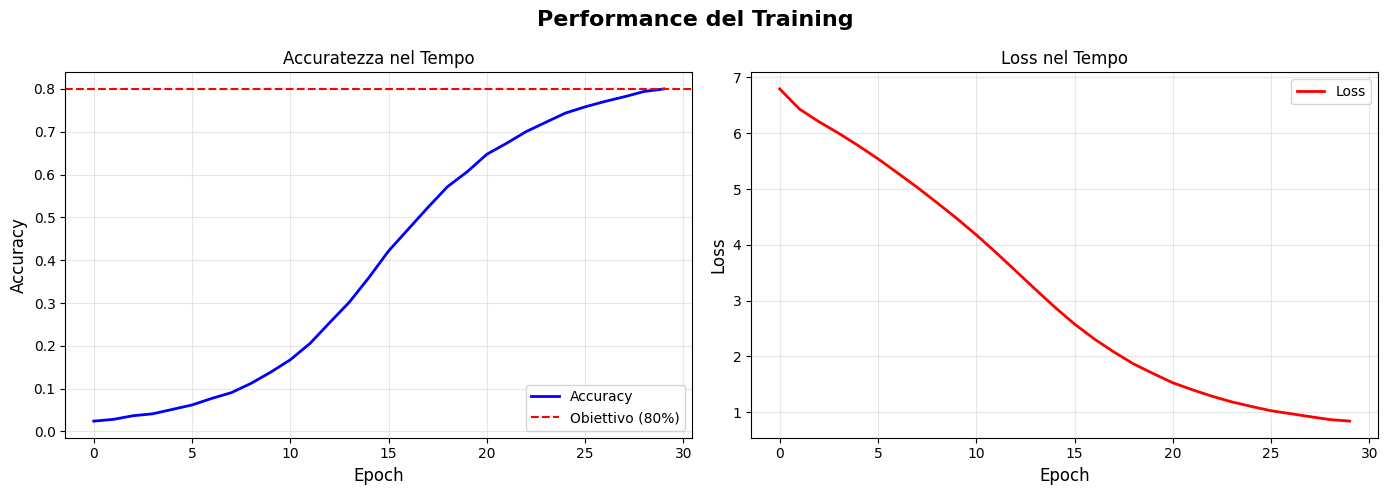


💡 Analisi:
   Accuracy iniziale: 2.41%
   Accuracy finale: 80.01%
   Miglioramento: +77.59%


In [ ]:
# Estraiamo i dati dal training
acc = history.history['accuracy']
loss = history.history['loss']
epochs_range = range(len(acc))

# Creiamo i grafici
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Performance del Training', fontsize=16, fontweight='bold')

# Grafico Accuracy
ax[0].plot(epochs_range, acc, 'b-', linewidth=2, label='Accuracy')
ax[0].axhline(y=0.8, color='r', linestyle='--', label='Obiettivo (80%)')
ax[0].set_xlabel('Epoch', fontsize=12)
ax[0].set_ylabel('Accuracy', fontsize=12)
ax[0].set_title('Accuratezza nel Tempo')
ax[0].legend()
ax[0].grid(True, alpha=0.3)

# Grafico Loss
ax[1].plot(epochs_range, loss, 'r-', linewidth=2, label='Loss')
ax[1].set_xlabel('Epoch', fontsize=12)
ax[1].set_ylabel('Loss', fontsize=12)
ax[1].set_title('Loss nel Tempo')
ax[1].legend()
ax[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n💡 Analisi:")
print(f"   Accuracy iniziale: {acc[0]*100:.2f}%")
print(f"   Accuracy finale: {acc[-1]*100:.2f}%")
print(f"   Miglioramento: +{(acc[-1]-acc[0])*100:.2f}%")

In [ ]:
# Salviamo la history per eventuali analisi future
with open('history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

print("✓ History salvata in 'history.pkl'")

✓ History salvata in 'history.pkl'


# Sezione test

In [ ]:
# Test veloce: predici la prossima parola
seed_text = "shall i compare thee"  # ← Cambia questa frase

# Converti in token e applica padding
token_list = vectorizer(seed_text).numpy()
token_list = tf.keras.preprocessing.sequence.pad_sequences(
    [token_list],
    maxlen=max_sequence_len-1,
    padding='pre'
)

# Predici
predicted = model.predict(token_list, verbose=0)
predicted_id = np.argmax(predicted)

# Risultato
next_word = vectorizer.get_vocabulary()[predicted_id]
print(f"Frase: '{seed_text}'")
print(f"Prossima parola: '{next_word}'")

Frase: 'shall i compare thee'
Prossima parola: 'to'


## Conclusioni 📊

In questo notebook è stato affrontato il problema della **predizione della parola successiva** utilizzando una rete neurale ricorrente **LSTM**, applicata a un corpus testuale letterario (Shakespeare).

L’esperimento mostra come un modello LSTM sia in grado di apprendere **strutture sintattiche e dipendenze sequenziali** nel testo, migliorando progressivamente la qualità delle predizioni man mano che l’addestramento procede. La fase di tokenizzazione e la scelta della lunghezza delle sequenze risultano cruciali per la stabilità e l’efficacia del modello.

I risultati evidenziano sia il potenziale delle RNN nel language modeling, sia i loro limiti, come la sensibilità agli iperparametri e la difficoltà nel catturare dipendenze molto lunghe rispetto a modelli più moderni.

Possibili estensioni includono:
- l’uso di **GRU o Transformer**
- l’analisi qualitativa del testo generato
- l’addestramento su corpus più ampi o diversificati

Questo notebook rappresenta una solida introduzione pratica ai modelli sequenziali per il linguaggio naturale.